
# Realistic float behavior, no control


---

## Equations of motion

Equations governing the float behavior are taken from P. Lherminier thesis (Annex 3, [link](https://tel.archives-ouvertes.fr/tel-00881646)):
which is strongly inspired from Voorhis (1971) (link).
They may account for water motions.
We ignore rotational dynamics which is less relevant when the float is not equipped with propellers.

<img src="float_displacement.png" alt="Drawing" align="right" style="width: 300px;"/>

Central variables are:
- $z_f$ : float vertical position
- $z_w$ : water vertical position
- $z_r=z_w-z_f$: water vertical position with respect to the float position

Corresponding velocities are:
$w_f=\frac{dz_f}{dt}$, $w=\frac{dz_w}{dt}$, $w_r=w-w_f$

The dynamical equation ruling the float vertical displacement is:

$$
\begin{align*}
m \frac{d^2z_f}{dt^2} = m \frac{dw_f}{dt} = \Pi - mg - D,
\end{align*}
$$

where:
- $\Pi$ represents the vertical component induced by pressure forces on the float.
- $D$ is the vertical force exerted by viscous drag forces.

Pressure forces are decomposed into one contribution due to pressure fields in the absence of the float
($\Pi_0$) and one contribution associated with disruptions of the flow by the float ($\Pi'$).

$$
\begin{align*}
\Pi_0 &= -V\partial_z p = -\frac{m}{\rho_f} \partial_z p \\
&= \frac{mg\rho_w}{\rho_f} + m \frac{\rho_w}{\rho_f} \frac{Dw}{Dt}
\end{align*}
$$

where $Dw/Dt$ is the vertical acceleration of water.
Densities are given by the float and water equations of state which may be linearized or not:

$$
\begin{align*}
\rho_w &= \rho_w(p,T,S) \\
\rho_f &= \rho_f(p,T) = \frac{m}{V(T,P)+v}\\
\end{align*}
$$

where $V$ represents the bulk of the float volume that may be affected by pressure and temperature and $v$ is the volume taken in and out by the pump.

For large water motions with respect to float length, disruptions of the pressure field by the float lead to a drag that is proportional to the square of relative velocity:

$$
\begin{align*}
\Pi' &= \frac{m}{L_v} \Big | \frac{dz_r}{dt} \Big | \frac{dz_r}{dt},
\end{align*}
$$

where $L_v$ is a drag lengthscale that is comparable to the length of the float $L_f$.
Not that if water is still: $z_r=-z_f$.

We ignore viscous forces for now.

Assumptions:
- the float follows horizontal motions exactly
- no viscous forces

Additional assumptions made in this notebook: 
- instantaneous thermal equilibrium

In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import time
from copy import deepcopy

from matplotlib import animation, rc
from IPython.display import HTML

from float_lib import *


---

## Start by selecting a water stratification profile

We use the World Ocean Atlas: [link](https://www.nodc.noaa.gov/OC5/woa13/)

The script implementing water profile objects is found [here](https://github.com/apatlpo/cognac/blob/master/instrum/float_lib.py)



WOA water profile at lon=-50, lat=40


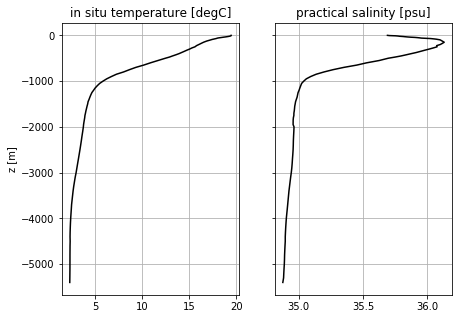

std::bad_cast
std::bad_cast


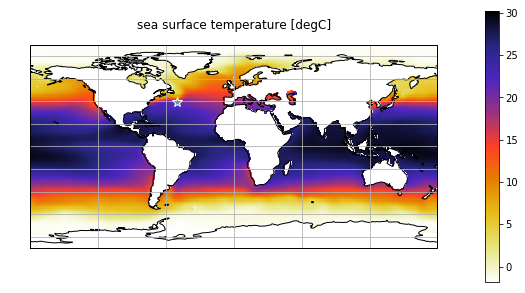

In [2]:
w = waterp(lon=-50.,lat=40.)
print(w)
w.show_on_map()

---

## Create a synthetic float

The script implementing float objects is found [here](https://github.com/apatlpo/cognac/blob/master/instrum/float_lib.py)

The float is less compressible than water here and naturally stable.

Float parameters: 
  L     = 0.40 m      - float length
  a     = 0.05 m      - float radius
  m     = 3.14 kg     - float radius
  gamma = 2.00e-06 /dbar  - mechanical compressibility
  alpha = 7.00e-05 /degC  - thermal compressibility
  temp0 = 1.50e+01 /degC  - reference temperature

Uses a uniform temperature in water density computation, temp= 19.5 degC
Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=-1.5e-02 m^2/s, fmin/m= 7.1e-03 m^2/s, wmax= 7.7 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax -8.8e+01 cm/s, fmin/m= 4.3e+01 cm/s


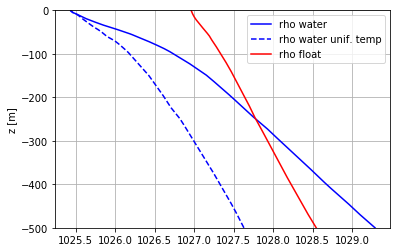

In [3]:
#
f = autonomous_float()
print(f)

# compute densities densities
z=np.arange(-500.,0.,1.)
#
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)
rho_w_notemp = w.get_rho(z,ignore_temp=True)
iz = np.argmin(np.abs(z+250))
f.v = f.adjust_balast(p[iz],temp[iz],rho_w[iz])
rho_f=f.rho(p,temp)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

plt.figure()
ax = plt.subplot(111)
#
ax.plot(rho_w,z,'b',label='rho water')
ax.plot(rho_w_notemp,z,'b--',label='rho water unif. temp')
ax.plot(rho_f,z,'r',label='rho float')
ax.legend()
ax.set_ylim((-500,0.))
ax.set_ylabel('z [m]')
ax.grid()

Start time stepping for 180 min ...
... time stepping done


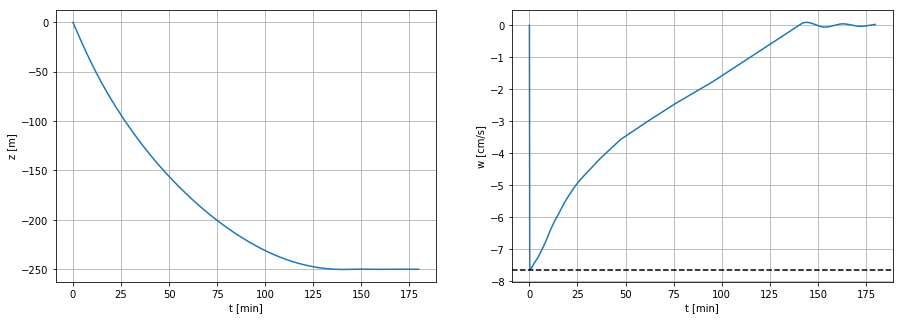

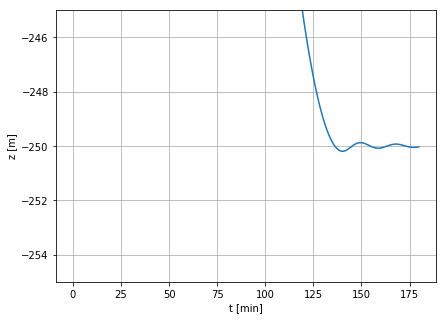

In [4]:
# time step
f.time_step(w,T=3*3600.,dt_step=1.,dt_store=10.,z=0.,w=0.)

plt.figure(figsize=(15,5))
ax=plt.subplot(121)
ax.plot(f.X[:,0]/60.,f.X[:,1])
ax.set_xlabel('t [min]')
ax.set_ylabel('z [m]')
ax.grid()
ax=plt.subplot(122)
ax.plot(f.X[:,0]/60.,f.X[:,2]*100.)
ax.set_xlabel('t [min]')
ax.set_ylabel('w [cm/s]')
#ax.set_xlim((0,10))
ax.axhline(-wmax*100.,color='k',linestyle='--')
ax.grid()

plt.figure(figsize=(15,5))
ax=plt.subplot(121)
ax.plot(f.X[:,0]/60.,f.X[:,1])
ax.set_xlabel('t [min]')
ax.set_ylabel('z [m]')
ax.set_ylim((-255,-245))
ax.grid()



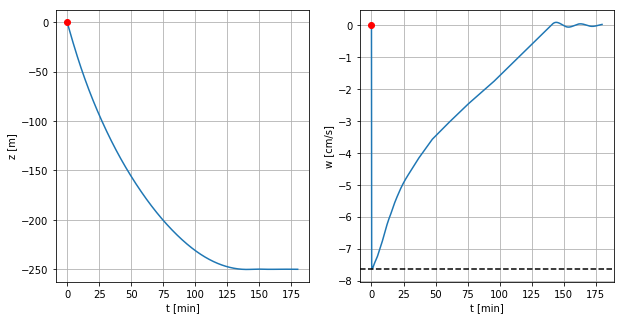

In [5]:
# same but with an animation !

fig=plt.figure(figsize=(10,5))
ax=plt.subplot(121)
ax.plot(f.X[:,0]/60.,f.X[:,1])
ax.set_xlabel('t [min]')
ax.set_ylabel('z [m]')
ax.grid()
lnz, = plt.plot([], [], 'ro', animated=True)
ax=plt.subplot(122)
ax.plot(f.X[:,0]/60.,f.X[:,2]*100.)
ax.set_xlabel('t [min]')
ax.set_ylabel('w [cm/s]')
#ax.set_xlim((0,10))
ax.axhline(-wmax*100.,color='k',linestyle='--')
ax.grid()
lnw, = plt.plot([], [], 'ro', animated=True)


def update_figure(i):
    lnz.set_data(f.X[i,0]/60.,f.X[i,1])
    lnw.set_data(f.X[i,0]/60.,f.X[i,2]*100.)
    return lnz,lnw
    
anim = animation.FuncAnimation(fig, update_figure,frames=f.X.shape[0], interval=20, blit=False)
HTML(anim.to_html5_video())



## [Link](https://player.vimeo.com/video/245705398) to online video

---

## Unstable case

This happens when the float is more compressible than water


Float parameters: 
  L     = 0.40 m      - float length
  a     = 0.05 m      - float radius
  m     = 3.14 kg     - float radius
  gamma = 5.00e-05 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 1.50e+01 /degC  - reference temperature

499
Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=4.4e-04 m^2/s, fmin/m= -2.2e-01 m^2/s, wmax= 29.5 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 2.6e+00 cm/s, fmin/m= -1.3e+03 cm/s


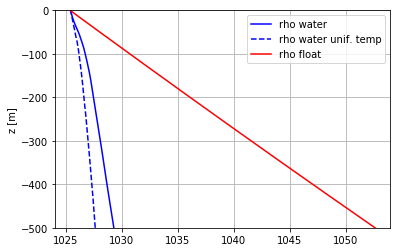

In [6]:
#
f = autonomous_float(gamma=50.e-6,alpha=0.)
print(f)

# compute densities densities
z=np.arange(-500.,0.,1.)
#
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)
iz = np.argmin(np.abs(z+0))
print(iz)
f.v = f.adjust_balast(p[iz],temp[iz],rho_w[iz])
rho_f=f.rho(p,temp)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

plt.figure()
ax = plt.subplot(111)
#
ax.plot(rho_w,z,'b',label='rho water')
ax.plot(rho_w_notemp,z,'b--',label='rho water unif. temp')
ax.plot(rho_f,z,'r',label='rho float')
ax.legend()
ax.set_ylim((-500,0.))
ax.set_ylabel('z [m]')
ax.grid()

Start time stepping for 180 min ...
... time stepping done


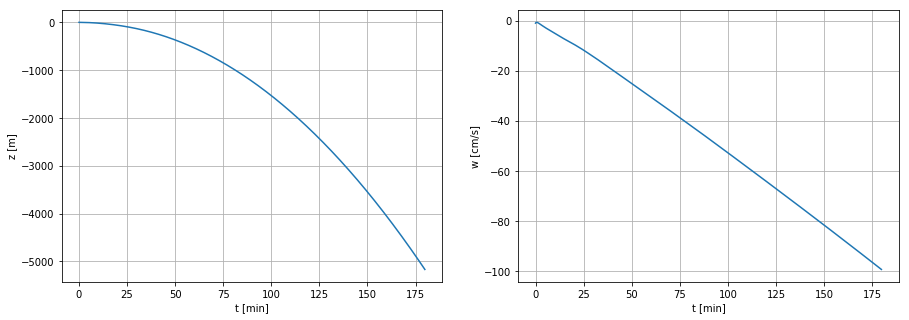

In [7]:
# time step
f.time_step(w,T=3*3600.,dt_step=.1,dt_store=10.,z=-1.,w=-.01)

plt.figure(figsize=(15,5))
ax=plt.subplot(121)
ax.plot(f.X[:,0]/60.,f.X[:,1])
ax.set_xlabel('t [min]')
ax.set_ylabel('z [m]')
ax.grid()
ax=plt.subplot(122)
ax.plot(f.X[:,0]/60.,f.X[:,2]*100.)
ax.set_xlabel('t [min]')
ax.set_ylabel('w [cm/s]')
ax.grid()


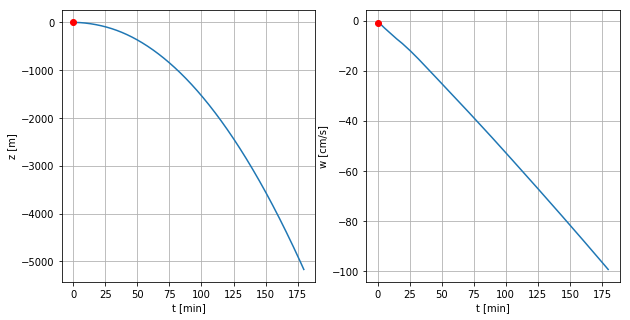

In [8]:
# same but with an animation !

fig=plt.figure(figsize=(10,5))
ax=plt.subplot(121)
ax.plot(f.X[:,0]/60.,f.X[:,1])
ax.set_xlabel('t [min]')
ax.set_ylabel('z [m]')
ax.grid()
lnz, = plt.plot([], [], 'ro', animated=True)
ax=plt.subplot(122)
ax.plot(f.X[:,0]/60.,f.X[:,2]*100.)
ax.set_xlabel('t [min]')
ax.set_ylabel('w [cm/s]')
ax.grid()
lnw, = plt.plot([], [], 'ro', animated=True)


def update_figure(i):
    lnz.set_data(f.X[i,0]/60.,f.X[i,1])
    lnw.set_data(f.X[i,0]/60.,f.X[i,2]*100.)
    return lnz,lnw
    
anim = animation.FuncAnimation(fig, update_figure,frames=f.X.shape[0], interval=20, blit=False)
HTML(anim.to_html5_video())



## [Link](https://player.vimeo.com/video/245721008) to online video